# Linear regression with ECASLab

Let's try to perform a linear regression on time series data by exploiting *PyOphidia*, *numpy* and *matplotlib* for the visualization.


### Connect to Ophidia
First of all import the PyOphidia modules and connect to the server-side:

In [1]:
from PyOphidia import cube
cube.Cube.setclient(read_env=True)

Current cdd is /home/lcapoccia
Current session is https://ophidialab.cmcc.it/ophidia/sessions/375259957913406033441558432939667105/experiment
Current cwd is /
The last produced cube is https://ophidialab.cmcc.it/ophidia/2908/292911


### Loading the dataset

In [2]:
%%time
tasmin = cube.Cube(src_path='/public/data/ecas_training/tasmin_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc',
    measure='tasmin',
    import_metadata='yes',
    imp_dim='time',
    imp_concept_level='d', vocabulary='CF',hierarchy='oph_base|oph_base|oph_time',
    ncores=4,
    description='Min Temps'
    )

New cube is https://ophidialab.cmcc.it/ophidia/2926/345396
CPU times: user 5.59 ms, sys: 1.96 ms, total: 7.54 ms
Wall time: 1.52 s


### Extract a time series
Extract a single time series from the imported cube by taking the values at precise latitude and longitude:

In [3]:
# We will extract the time series by taking the time for 
# the first couple of latitude and longitude in the data-set
filtered_tasmin = tasmin.subset2(
    subset_dims="lat|lon",
    subset_filter="-87.159095|0.000000",
    ncores=5)

# Print the data
data = filtered_tasmin.export_array(show_time='no')

### Let's extract trainig and test set
Divide the time series into training and test sets, by taking the 80% as training set and the remainig 20% as test set:


In [4]:
size = len(data['measure'][0]['values'][0][:])

x_train = filtered_tasmin.subset2(
    subset_dims="time",
    subset_filter="0:" + str(int(.8 * size)),
    ncores=5)

x_test = filtered_tasmin.subset2(
    subset_dims="time",
    subset_filter=str(int(.8 * size)) + ":" + str(size),
    ncores=5)

### Ophidia regression
Let's run the Ophidia primitive to perform the linear regression over the training part of the time series.
We can do so by applying the *oph_gsl_fit_linear* primitive.

In [5]:
results = x_train.apply(
    query="oph_gsl_fit_linear_coeff('oph_float','oph_double',measure,dimension,'111111')"
)

The results of the command are:

In [6]:
results.explore()


tasmin
------
+============+==========+============================================================================================+
| lat        | lon      | tasmin                                                                                     |
+============+==========+============================================================================================+
| -87.159095 | 0.000000 | 236.0657452814, 0.0006232219, 0.3117355803, -0.0003202763, 0.0000004387, 165896.2653960325 |
+============+==========+============================================================================================+
Summary
-------
Selected 1 row out of 1


Execution time: 0.17 seconds


where we have, in order:
- the intercept of the regression line;
- the slope of the regression line;
- the term 'cov00' of the covariance matrix;
- the term 'cov01' of the covariance matrix;
- the term 'cov10' of the covariance matrix;
- the error calculated as sum of squares of the residuals.

### Plot the results
Let's now plot the training examples and the regression line.

Let's first extract the data that will be usefull to us:

In [7]:
regression_data = results.export_array(show_time='no')

intercept = regression_data['measure'][0]['values'][0][0]
slope = regression_data['measure'][0]['values'][0][1]
error = regression_data['measure'][0]['values'][0][5]

Let's do some predictions and let's plot the regression: 

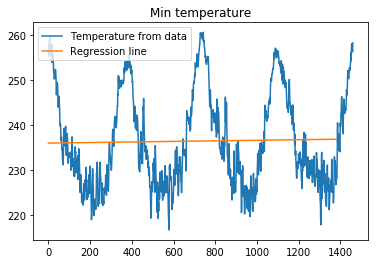

In [8]:
train_set = x_train.export_array()

time = train_set['dimension'][2]['values']
temperatures = train_set['measure'][0]['values'][0]

import matplotlib.pyplot as plt
import numpy as np

plt.plot(time, temperatures, '-', label='Temperature from data')

time_range = np.arange(0, 1400, 30)
y_predicted = (time_range * slope) + intercept

plt.plot(time_range, y_predicted, '-', label='Regression line')
plt.title('Min temperature')
plt.legend()

plt.show()

The regression shows the trend, so it shows how the average temperature goes along with the time, instead of the temperature itself. This happens because the temperature fluctate a lot in the time interval considered.
### Compare the regression output
We will compare the regression output from Ophidia with those computed through the normal equation implementation.

Let's first import the procedure implementing the normal equation:

In [9]:
def normal_equations(x, y):
    return np.linalg.pinv(x.T.dot(x)).dot(x.T).dot(y)

Let's buil the dataset first, and then let's calculate the parameters:

In [10]:
ones__array = np.ones(len(time)).reshape((len(time), 1))
time_array = np.concatenate([time]).reshape((len(time), 1))
_x_train = np.concatenate([ones__array, time_array], axis=1)
_y_train = np.concatenate([temperatures])
theta = normal_equations(_x_train, _y_train)

We can plot the results to see the differences:

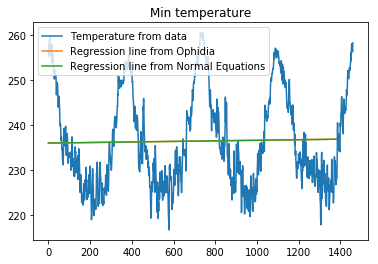

In [11]:
train_set = x_train.export_array()

time = train_set['dimension'][2]['values']
temperatures = train_set['measure'][0]['values'][0]

plt.plot(time, temperatures, label='Temperature from data')

time_range = np.arange(0, 1400, 30)
y_predicted = (time_range * slope) + intercept

plt.plot(time_range, y_predicted, label='Regression line from Ophidia')

y_normal = (time_range * theta[1]) + theta[0]
plt.plot(time_range, y_normal, label='Regression line from Normal Equations')

plt.title('Min temperature')
plt.legend()
plt.show()

The graph show that the lines overlaps, so the parameters are the same in both cases.
### Error comparison
Let's verify the results on the test part of the data vs the training set. To do so, we need to calculate the prediction on the test data:

In [12]:
# Download the test set and put it in a dictionary
test_data = x_test.export_array(show_time='no')

# Split into prediction variable and measure
X_test = np.array(test_data['dimension'][2]['values'])
Y_test = np.array(test_data['measure'][0]['values'][0])

Let's now apply our prediction model to calculate the predicted temperatures:

In [13]:
predicted_temperatures = (X_test * slope) + intercept

As it can be seen in the *oph_gsl_fit_linear_coeff* operator page, the error calculated by the Ophidia framework is the sum of squared error, so we need to implement it, which is the error calculated as follows:
$$ SSE = \sum_{i=0}^n (y^{(i)}-\hat{y}^{(i)})^2 $$
where:
- $y^{(i)}$ represents the measure of the i-th example
- $\hat{y}^{(i)}$ represents the predicted value

In [14]:
error_test = np.sum((Y_test - predicted_temperatures) ** 2)

In [15]:
print("The number of the training examples is {}"
      .format(_x_train.shape[0]))
print("The number of the test examples is {}"
      .format(Y_test.shape[0]))

The number of the training examples is 1460
The number of the test examples is 366


Using such a performance metrics is not the best thing to do, as it is highly dependent on the number of values being summed. To compare the errors, we need to take the mean with respect to the number of example used to calcalate the metrics:

In [16]:
error = error / _x_train.shape[0]
error_test = error_test / Y_test.shape[0]

We can now plot the comparison:

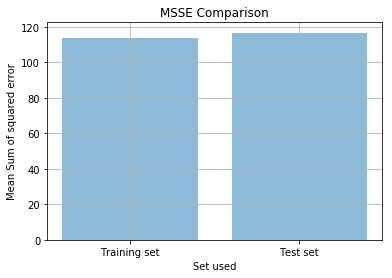

In [17]:
objects = ('Training set', 'Test set')
y_pos = np.arange(len(objects))
performance = [error, error_test]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean Sum of squared error')
plt.xlabel('Set used')
plt.title('MSSE Comparison')
plt.grid(b=True)
plt.show()

# Autoregressive model
The model will be:
$$ y_t = \theta_0 + \theta_1 y_{t-1} $$
So, instead of using the time as prediction variable, we need to use the value of the temperature at the previous time. Hence, the model becomes a lot more linear because the temperature fluctuate in a smoothly way. 

In [18]:
x_train_ar = np.roll(_y_train, -1)

num_training_examples = x_train_ar.shape[0]-1
x_train_ar = x_train_ar[:num_training_examples]
_y_train = _y_train[:num_training_examples]

prediction_var = x_train_ar

The fluctuation of the temperature is linear, so it is more meaningful to predict the temperature on this model instead of the previous one. Let's show how the temperature fluctuate: 

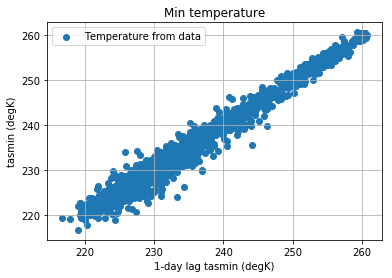

In [19]:
plt.scatter(x_train_ar, _y_train, label='Temperature from data')
plt.ylabel('tasmin (degK)')
plt.xlabel('1-day lag tasmin (degK)')
plt.title('Min temperature')
plt.legend()
plt.grid(b=True)
plt.show()

We can apply the regression now, so let's create the dataset and let's calculate the $\theta$ parameter using the normal equation:

In [20]:
ones__array = np.ones(len(x_train_ar)).reshape((len(x_train_ar), 1))
x_train_ar = np.concatenate([x_train_ar]).reshape((len(x_train_ar), 1))
x_train_ar = np.concatenate([ones__array, x_train_ar], axis=1)

theta = normal_equations(x_train_ar, _y_train)

We can plot the line representing the trained model over the training set:

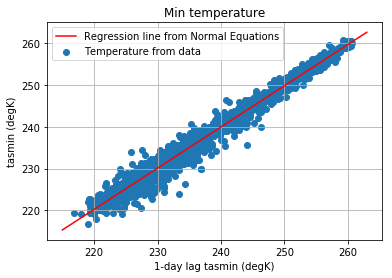

In [21]:
plt.scatter(prediction_var, _y_train, label='Temperature from data')

time_range = np.arange(215, 265, 2)

y_normal = (time_range * theta[1]) + theta[0]
plt.plot(time_range, y_normal, label='Regression line from Normal Equations', color="r")
plt.ylabel('tasmin (degK)')
plt.xlabel('1-day lag tasmin (degK)')
plt.title('Min temperature')
plt.legend()
plt.grid(b=True)
plt.show()

Let's now download the test set from Ophidia and let's convert it in the format we will use:

In [22]:
# Download the test set and put it in a dictionary
test_data = x_test.export_array(show_time='no')

# Split into prediction variable and measure
Y_test = np.array(test_data['measure'][0]['values'][0])
X_test = np.roll(Y_test, -1)

num_test_examples = Y_test.shape[0]-1
X_test = X_test[:num_test_examples]
Y_test = Y_test[:num_test_examples]

We can now make some predictions and we can calulate the mean sum of squared errors over the test set:

In [23]:
predicted_temperatures = (X_test * theta[1]) + theta[0]

# Calculate SSE
error_test_ar = np.sum((Y_test - predicted_temperatures) ** 2) / Y_test.shape[0]

Let's compare the result obtained from the different kinds of models used:

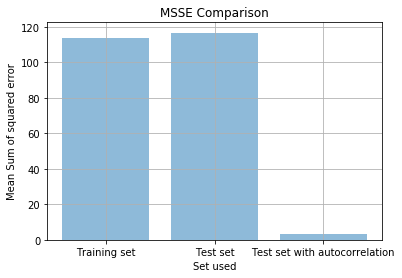

In [24]:
objects = ('Training set', 'Test set', 'Test set with autocorrelation')
y_pos = np.arange(len(objects))
performance = [error, error_test, error_test_ar]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean Sum of squared error')
plt.xlabel('Set used')
plt.title('MSSE Comparison')
plt.grid(b=True)
plt.show()

The graph shows that the autoregressive model is a lot more performant instead of the other models that use the time as the indipendent variable.

### Clear the workspace
Let's now clear the workspace from the datacubes produced during the experiments, releasing the resources occupied.

In [25]:
cube.Cube.client.submit("oph_delete cube=[container=tasmin_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc]")
cube.Cube.deletecontainer(container='tasmin_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc')